In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import scipy.signal as sig
import dispest

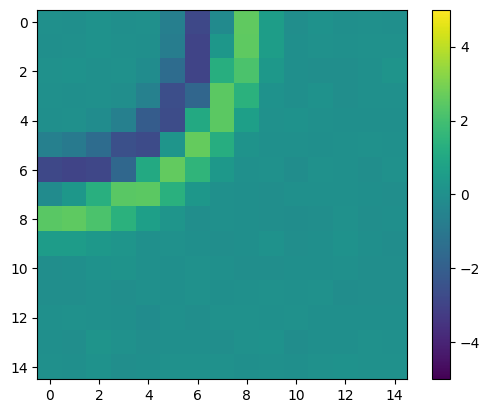

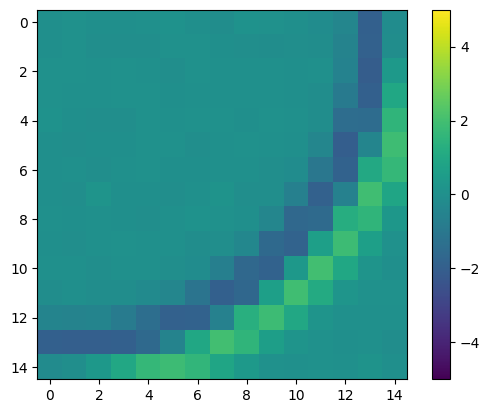

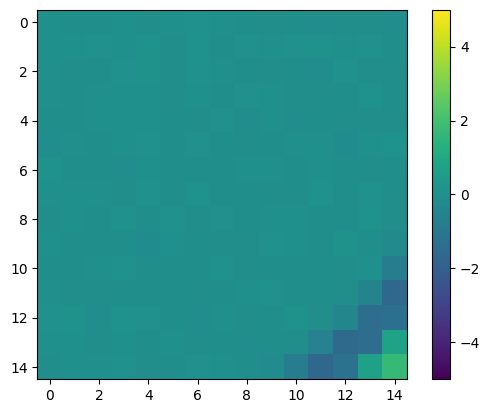

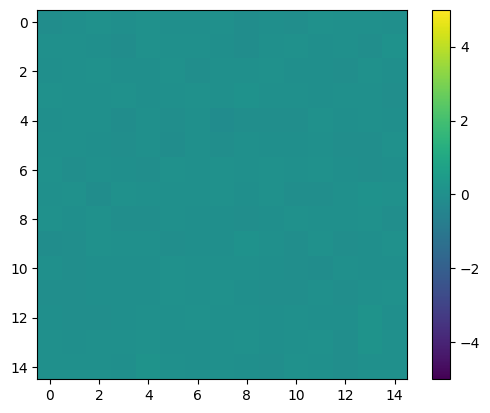

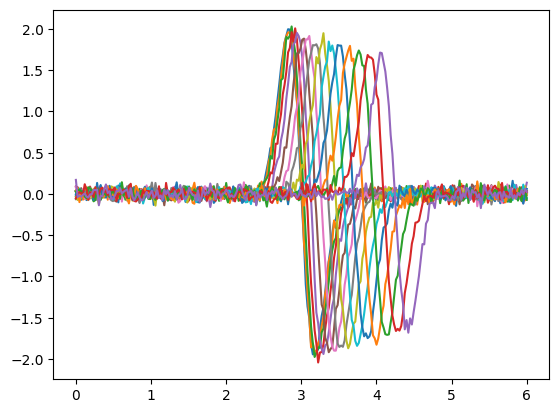

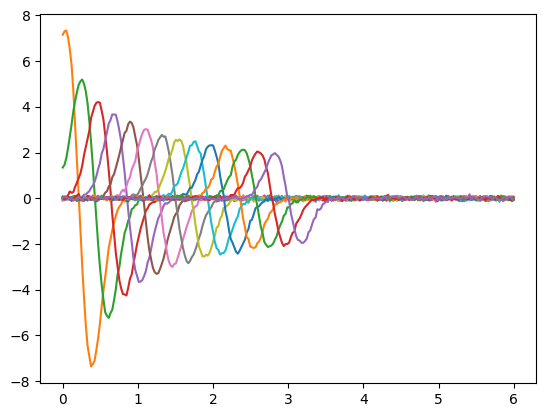

In [79]:
xi = np.linspace(0, 3, 15)
t = np.linspace(0, 6, 256)
c = 1
X, Y = np.meshgrid(xi,xi, indexing='ij')

R = np.hypot(X, Y)
PHI = np.arctan2(Y, X)

rng = np.random.default_rng()

wave = np.gradient(np.exp(-((R[:,:,None] - c* t[None,None,:])/0.25)**2)/np.sqrt(1E-6+np.abs(R[:,:,None])), t[1]-t[0], axis=2)
wave[0,0,:] = 0
wave = wave + rng.normal(0, 0.05, wave.shape)

plt.figure()
plt.imshow(wave[:,:,64], vmin=-5, vmax=5)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(wave[:,:,128], vmin=-5, vmax=5)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(wave[:,:,172], vmin=-5, vmax=5)
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(wave[:,:,255], vmin=-5, vmax=5)
plt.colorbar()
plt.show()


plt.figure()
plt.plot(t, wave[-1,:,:].T)
plt.show()
plt.figure()
plt.plot(t, wave[0,:,:].T)
plt.show()

In [80]:
signals = np.array(wave.reshape(-1, len(t)))
pi = []
pj = []
for ii in range(1,signals.shape[1]):
    for jj in range(ii+1,signals.shape[0]):
        pi.append(ii)
        pj.append(jj)
pi = np.array(pi)
pj = np.array(pj)

signals.shape, pi.shape, pj.shape

((225, 256), (24976,), (24976,))

In [4]:
NXCORR_PAIRWISE_W_VAR_SRC = r'''
extern "C"

__global__ void correlate(
        const float *sig,   // signal tensor [Np x Ns]
        const int *pref,    // refernce signal index [Npp]
        const int *pser,    // search signal index [Npp]
        float *covar,       // reference-search covariance [Npp x Ncc x (2*Npm + 1)]
        float *rvar,        // reference kernel variance [Npp x Ncc x (2*Npm + 1)]
        float *svar,        // search kernel variance [Npp x Ncc x (2*Npm + 1)],
        int Ns,
        int Np,
        int Npp,
        int Ncc,
        int Npm,
        int t0,
        int dt,
        int Nt
    ) 
{
    // calculate the point pair index and ensure it is within bounds
    int ippsr = blockIdx.x * gridDim.y + blockIdx.y;
    if (ippsr >= Npp) return;
    int ipref = Ns * pref[ippsr];
    int ipser = Ns * pser[ippsr];

    // calculate the bounds of the reference kernel
    int t0kref = t0 + dt * blockIdx.z;
    int trmin = t0kref;
    int trmax = t0kref + Nt;

    // calculate the bounds of the search kernel
    int dtsearch = threadIdx.x - Npm;
    int tsmin = t0kref + dtsearch;
    int tsmax = t0kref + dtsearch + Nt;

    // adjust kernel bounds to be within signal bounds
    if (trmin < 0) {tsmin -= trmin; trmin = 0;}
    if (tsmin < 0) {trmin -= tsmin; tsmin = 0;}
    if (trmax > Ns) {tsmax -= trmax - Ns; trmax = Ns;}
    if (tsmax > Ns) {trmax -= tsmax - Ns; tsmax = Ns;}
    int Nit = trmax - trmin;

    // calculate mean of each kernel
    float muref, muser = 0.0f;
    for(int it = 0; it < Nit; ++it)
    {
        muref += sig[ipref + trmin + it]; 
        muser += sig[ipser + tsmin + it];
    }
    muref /= Nt;
    muser /= Nt;

    // calculate covar and var for the kernels
    float cov, varr, vars, xs, xr = 0.0f;
    for(int it = 0; it < Nit; ++it)
    {
        xr = (sig[ipref + trmin + it] - muref);
        xs = (sig[ipser + tsmin + it] - muser);
        cov  += xr * xs; 
        vars += xs * xs;
        varr += xr * xr;
    }
    cov  /= Nt;
    vars /= Nt;
    varr /= Nt;
    
    // save results
    ipref = (2*Npm + 1) * (Ncc * ippsr + blockIdx.z) + threadIdx.x;
    covar[ipref] = cov;
    svar[ipref] = vars;
    rvar[ipref] = varr;
}
'''

In [98]:
PAIRWISE_QUAD_PEAK_W_VAR_W_DANDI = r'''
extern "C"

__global__ void quadratic_peak(
        const float *COVAR, // reference-search covariance [Npp x Ncc x (2*Npm + 1)]
        const float *RVAR,  // reference kernel variance [Npp x Ncc x (2*Npm + 1)]
        const float *SVAR,  // search kernel variance [Npp x Ncc x (2*Npm + 1)]
        float *ncc,         // interpolated peak reference-search covariance [Npp x Ncc]
        float *rvar,        // peak-index reference kernel variance [Npp x Ncc]
        float *svar,        // peak-index search kernel variance [Npp x Ncc]
        float *dlag,        // interpolated fractional sub-index lag [Npp x Ncc]
        int *ilag,          // indical lag [Npp x Ncc]
        const int Npp,      // number of point pairs being evaluated
        const int Ncc,      // number of refernce locations being evaluated
        const int Npm,      // half search range
        const float epsilon // minimum 
    ) 
{
    // indexing and placeholder variable allocation for ~speed~
    int ippsr, icc, it0, Nt, ipeak, iccout;
    float cc2it, cc2max, nccneg, nccmid, nccpos, a, b, c, dlag0;

    // calculate the point pair index and ensure it is within bounds
    ippsr = blockIdx.x * gridDim.y + blockIdx.y;
    if (ippsr >= Npp) return;

    // calculate the reference kernel index
    icc = blockIdx.z * blockDim.x + threadIdx.x;
    if (icc >= Ncc) return;
    
    // calcualte index of COVAR/RVAR/SVAR corresponding to ippsr and icc
    Nt = (2*Npm + 1);
    it0 = (ippsr * Ncc + icc) * Nt;

    // find peak lag index and calculate sampled cc2
    ipeak = -1;
    cc2it = -1.0f;
    cc2max = -1.0f;
    for(int it = 0; it < Nt; ++it)
    {
        // ensure denominator is not zero
        if ((RVAR[it0 + it] * SVAR[it0 + it]) < epsilon) {cc2it = -1.0f;}
        // calculate cc2 for this lag
        else {cc2it =  COVAR[it0 + it] * COVAR[it0 + it] / (RVAR[it0 + it] * SVAR[it0 + it]);}
        if (cc2it > cc2max) {cc2max = cc2it; ipeak = it;}
    }

    // ensure valid peak has been found - two conditions...
    // 1. peak value cannot be at first or last index for centered quadratic fit to be valid
    if ((ipeak < 1) || (ipeak > 2*Npm)) return;
    // 2. neighboring points must have valid denominators -> cannot fit quadratic if a point is ~inf
    // ensure denominator is not zero at ipeak -1
    if ((RVAR[it0 + ipeak-1] * SVAR[it0 + ipeak-1]) < epsilon) return;
    // ensure denominator is not zero at ipeak +1
    if ((RVAR[it0 + ipeak+1] * SVAR[it0 + ipeak+1]) < epsilon) return;

    // fit points around peak to quadratic and interpolate to find sub-index lag
    nccneg = COVAR[it0 + ipeak - 1] / sqrt(RVAR[it0 + ipeak - 1] * SVAR[it0 + ipeak - 1]);
    nccmid = COVAR[it0 + ipeak] / sqrt(RVAR[it0 + ipeak] * SVAR[it0 + ipeak]);
    nccpos = COVAR[it0 + ipeak + 1] / sqrt(RVAR[it0 + ipeak + 1] * SVAR[it0 + ipeak + 1]);

    // find quadratic coefficients
    a = (nccpos + nccneg)/2 - nccmid;
    b = (nccpos - nccneg)/2;
    c = nccmid;

    // calculate relative location of maxima
    dlag0 = -b/(2*a);

    // put values in ouput buffers
    iccout = ippsr * Ncc + icc;
    ncc[iccout] = a * dlag0 * dlag0 + b * dlag0 + c;
    rvar[iccout] = RVAR[it0 + ipeak];
    svar[iccout] = SVAR[it0 + ipeak];
    dlag[iccout] = dlag0;
    ilag[iccout] = ipeak - Npm;
}
'''

In [121]:
from typing import Literal

def __test_gpu_driver(signals, pi, pj, 
                                 lenref:int, refstep:int, searchpm:int, istart:int=0, istop:int|None=None, 
                                 peakinterp:Literal[None, 'quadratic']='quadratic', 
                                 sumlags:bool=True, returnsigvar:bool=False):
    """Calculate the normalized cross correlation between arbitrary pairs of signals described by pi and pj
    
    # Parameters:
    `signals`: an (Np x Ns) matrix where Np is the number of signals and Ns is the number of samples
    `pi`: the index of the reference signal in [0, Np)
    `pj`: the index of the search signal in [0, Np)
    `lenref`: length of the reference kernel in samples
    `refstep`: number of samples between the beginning of each reference kernel
    `searchpm`: how many samples to search from the refernce kernel in either direction
    `istart`: the first index of the first kernel in the reference signal
    `istop`: the first index of the last kernel in the reference signal
    `peakinterp`: the method used for sub-index lag estimation
    `sumlags`: bool dictating if both the lag index and interpolated sub index shift are returned
    `returnsigvar`: dictates if signal variance at peak lag is returned

    # Returns:
    `cc`: (Np x (istop-istart)//refstep) matrix of peak correlation coefficients
    `lag` or `ilag`, `dlag`: either the summed or component indical and interpolated lags, depending on `sumlags`
    `rvar`, `svar`: the variance of refernce and search kernels at the indical lag shown by ilag
    `imids`: (istop-istart)//refstep length array of the average index of the refernce kernel
    """

    import cupy as cp

    if istop is None: istop = signals.shape[1]-lenref

    Ns = np.int32(signals.shape[1])
    Np = np.int32(signals.shape[0])
    Npp = np.int32(len(pi))
    Ncc = np.int32((istop-istart)//refstep)
    Npm = np.int32(searchpm)
    Nlag = np.int32(2*searchpm + 1)
    t0 = np.int32(istart)
    dt = np.int32(refstep)
    Nt = np.int32(lenref)

    # estimate covar and var
    if returnsigvar:
        #from dispest.nxcorr.__gpu_engines__ import NXCORR_PAIRWISE_W_VAR_SRC as code
        code = NXCORR_PAIRWISE_W_VAR_SRC
    else: raise NotImplementedError("No direction function yet")

    sig_gpu = cp.asarray(signals, dtype=cp.float32)
    pi_gpu = cp.asarray(pi, dtype=cp.int32)
    pj_gpu = cp.asarray(pj, dtype=cp.int32)
    COVAR = cp.zeros([Npp, Ncc, Nlag], cp.float32)
    RVAR = cp.zeros([Npp, Ncc, Nlag], cp.float32)
    SVAR = cp.zeros([Npp, Ncc, Nlag], cp.float32)

    nxc_params = (
        sig_gpu, pi_gpu, pj_gpu, 
        COVAR, RVAR, SVAR, 
        Ns, Np, Npp, Ncc, Npm, t0, dt, Nt
    )

    gridsize = (Npp, 1, Ncc,)
    blocksize = (Nlag,)

    CUDAENGINE = cp.RawKernel(code=code, name='correlate')
    CUDAENGINE(gridsize, blocksize, nxc_params)

    del sig_gpu, pi_gpu, pj_gpu

    # estimate lags
    ncc = cp.zeros([Npp, Ncc], cp.float32)
    rvar = cp.zeros([Npp, Ncc], cp.float32)
    svar = cp.zeros([Npp, Ncc], cp.float32)
    dlag = cp.zeros([Npp, Ncc], cp.float32)
    ilag = cp.zeros([Npp, Ncc], cp.int32)
    peak_params = (
        COVAR, RVAR, SVAR,
        ncc, rvar, svar, dlag, ilag,
        Npp, Ncc, Npm, cp.float32(0)
    )

    gridsize = (Npp, 1, 1,)
    blocksize = (Ncc,)
    code = PAIRWISE_QUAD_PEAK_W_VAR_W_DANDI
    CUDAENGINE = cp.RawKernel(code=code, name="quadratic_peak")
    CUDAENGINE(gridsize, blocksize, peak_params)
    del COVAR, RVAR, SVAR
    return ncc.get(), rvar.get(), svar.get(), dlag.get(), ilag.get()

ncc, rvar, svar, dlag, ilag = __test_gpu_driver(signals, pi, pj, lenref=64, refstep=4, searchpm=32, istart = 16, istop = None, returnsigvar=True)

In [100]:
dt=t[1]-t[0]
dt, 1.5/dt

(0.023529411764705882, 63.75)

In [104]:
len(t)

256

(9, 78)

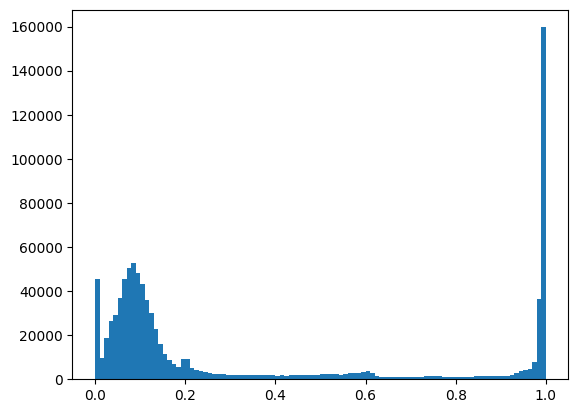

In [122]:
plt.figure()
plt.hist(ncc.flatten()**2, bins=np.linspace(0,1, 101))
plt.show()

14 194


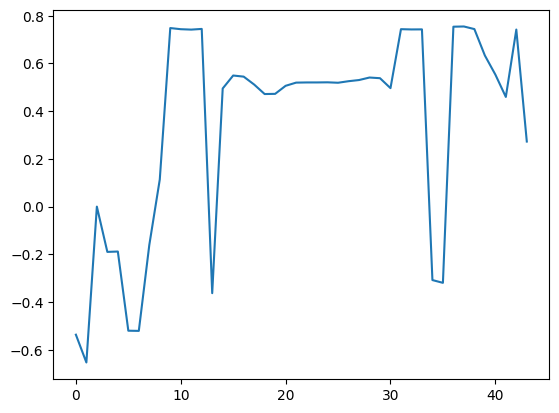

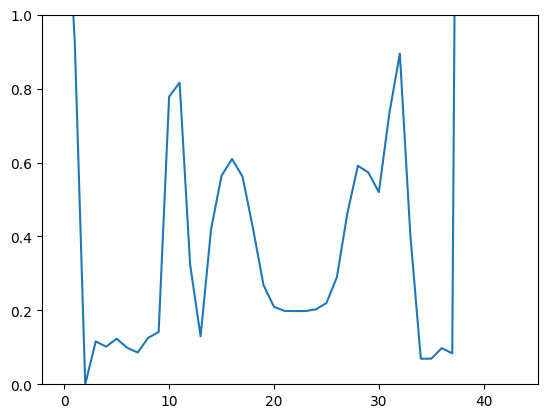

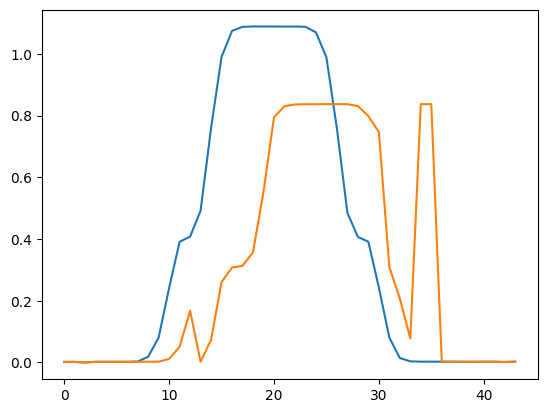

In [123]:
isel = 3000
print(pi[isel], pj[isel])
plt.figure()
plt.plot(dt*(dlag[isel]+ilag[isel]))
plt.show()
plt.figure()
plt.plot((ncc[isel]**2))
plt.ylim(0,1)
plt.show()

plt.figure()
plt.plot(rvar[isel])
plt.plot(svar[isel])
plt.show()